#### Data Preprocessing

In [ ]:
#Installing necessary packages
!pip install geopandas

#Installing needed geo based libraries
!pip install libpysal
!pip install splot
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 

# Install rtree - Geopandas requirment
!apt install python3-rtree 
!pip install pysal

In [ ]:
##Importing needed libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
import pysal
from libpysal import weights

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Loading demographic data 
demo_data_2018 = pd.read_csv('acs_ct_2018.csv')
demo_data_2018['year'] = '2018'
demo_data_2017 = pd.read_csv('acs_ct_2017.csv')
demo_data_2017['year'] = '2017'
demo_data_2016 = pd.read_csv('acs_ct_2016.csv')
demo_data_2016['year'] = '2016'
demo_data_2015 = pd.read_csv('acs_ct_2015.csv')
demo_data_2015['year'] = '2015'
demo_data_2014 = pd.read_csv('acs_ct_2014.csv')
demo_data_2014['year'] = '2014'
demo_data_2013 = pd.read_csv('acs_ct_2013.csv')
demo_data_2013['year'] = '2013'
demo_data_2012 = pd.read_csv('acs_ct_2012.csv')
demo_data_2012['year'] = '2012'
demo_data_2011 = pd.read_csv('acs_ct_2011.csv')
demo_data_2011['year'] = '2011'
demo_data_2010 = pd.read_csv('acs_ct_2010.csv')
demo_data_2010['year'] = '2010'

In [ ]:
demo_data_2018.head()

,geo_id,do_date,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,male_21,male_22_to_24,male_25_to_29,male_30_to_34,male_35_to_39,male_40_to_44,male_45_to_49,male_50_to_54,male_55_to_59,male_60_to_61,male_62_to_64,male_65_to_66,male_67_to_69,male_70_to_74,male_75_to_79,male_80_to_84,male_85_and_over,female_under_5,female_5_to_9,female_10_to_14,female_15_to_17,female_18_to_19,female_20,female_21,female_22_to_24,female_25_to_29,female_30_to_34,...,male_45_64_grade_9_12,male_45_64_high_school,male_45_64_some_college,male_45_to_64,employed_pop,unemployed_pop,pop_in_labor_force,not_in_labor_force,workers_16_and_over,armed_forces,civilian_labor_force,employed_agriculture_forestry_fishing_hunting_mining,employed_arts_entertainment_recreation_accommodation_food,employed_construction,employed_education_health_social,employed_finance_insurance_real_estate,employed_information,employed_manufacturing,employed_other_services_not_public_admin,employed_public_administration,employed_retail_trade,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,employed_wholesale_trade,occupation_management_arts,occupation_natural_resources_construction_maintenance,occupation_production_transportation_material,occupation_sales_office,occupation_services,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english,year
0,72119130101,2014-01-01,4971,1612,2455,2516,39.2,155,144,146,161,0,48,101,22,100,160,77,122,78,254,182,162,105,67,75,59,149,22,66,178,125,113,175,83,78,0,96,82,193,...,51,401,96,781,1404.0,529.0,1933.0,2128.0,1337.0,0.0,1933.0,0.0,181.0,18.0,297.0,53.0,34.0,108.0,125.0,125.0,308.0,97.0,58.0,0.0,379.0,0.0,215.0,362.0,448.0,379.0,362.0,197,192,357,1036,218,NaN,NaN,NaN,2018
1,72127009624,2014-01-01,3876,1548,1554,2322,39.3,49,119,103,81,40,94,52,14,116,71,80,70,60,158,96,45,77,0,46,38,53,61,31,146,100,129,127,18,67,16,136,178,67,...,0,52,74,436,1430.0,191.0,1621.0,1532.0,1430.0,0.0,1621.0,0.0,172.0,73.0,286.0,137.0,10.0,55.0,89.0,55.0,231.0,232.0,9.0,81.0,732.0,62.0,0.0,389.0,247.0,732.0,389.0,185,157,263,1124,323,NaN,NaN,NaN,2018
2,72021031612,2014-01-01,4591,1607,2004,2587,27.9,240,250,143,89,136,156,0,34,138,91,72,49,50,117,45,33,19,17,9,119,85,69,43,240,162,160,78,36,51,24,196,335,74,...,29,61,62,264,1124.0,372.0,1496.0,1850.0,1113.0,0.0,1496.0,0.0,177.0,30.0,263.0,68.0,9.0,72.0,82.0,91.0,107.0,169.0,27.0,29.0,359.0,55.0,80.0,356.0,274.0,359.0,356.0,342,263,236,1462,411,NaN,NaN,NaN,2018
3,72127009111,2014-01-01,2584,1466,1076,1508,51.3,9,100,90,39,53,0,12,22,72,52,44,141,31,58,99,25,9,8,52,85,50,25,0,42,0,18,32,36,25,0,57,22,43,...,58,39,30,222,937.0,145.0,1082.0,1232.0,924.0,0.0,1082.0,0.0,50.0,21.0,352.0,124.0,23.0,23.0,34.0,74.0,113.0,75.0,23.0,25.0,470.0,12.0,23.0,319.0,113.0,470.0,319.0,42,129,84,568,183,NaN,NaN,NaN,2018
4,72025201000,2014-01-01,2037,910,784,1253,39.6,49,40,56,27,50,0,35,44,26,27,45,6,43,55,58,18,33,11,22,49,70,20,0,42,86,117,38,40,23,0,70,55,107,...,0,67,42,207,585.0,145.0,730.0,917.0,542.0,0.0,730.0,0.0,159.0,0.0,150.0,25.0,0.0,53.0,64.0,8.0,33.0,67.0,0.0,26.0,82.0,15.0,85.0,158.0,245.0,82.0,158.0,154,89,141,538,116,NaN,NaN,NaN,2018


In [ ]:
#Loading social vulnerability data
svi_2018 = pd.read_csv('NewYork_2018.csv')
svi_2018['year'] = '2018'
svi_2016 = pd.read_csv('NewYork_2016.csv')
svi_2016['year'] = '2016'
svi_2014 = pd.read_csv('NewYork_2014.csv')
svi_2014['year'] = '2014'
svi_2010 = pd.read_csv('NewYork_2010.csv')
svi_2016['year'] = '2010'
svi_2000 = pd.read_csv('NewYork_2000.csv')
svi_2000['year'] = '2000'

In [ ]:
svi_2018.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,...,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,year
0,36,NEW YORK,NY,36001,Albany,36001000100,"Census Tract 1, Albany County, New York",0.914079,2022,218,957,53,837,70,646,248,113,63,18261,2740,254,71,239,63,602,115,323,114,156,58,1666,239,61,54,26,32,0,12,0,17,...,0.9374,0.7672,0.5447,1.3119,0.6534,0.3414,0.0,0.0000,0.5634,0.6023,1.5071,0.2134,9.1772,0.8139,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,128,57,6.3,2.8,3031,2018
1,36,NEW YORK,NY,36001,Albany,36001000200,"Census Tract 2, Albany County, New York",0.797363,4700,690,2978,173,2133,224,1582,524,242,149,26297,5938,433,166,304,106,1087,425,455,161,422,182,4178,719,60,72,464,147,0,12,15,25,...,0.5116,0.8118,0.3396,1.1514,0.5637,0.6210,0.0,0.2272,0.7192,0.7695,2.3369,0.5584,8.5731,0.7373,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,595,362,12.7,7.4,4806,2018
2,36,NEW YORK,NY,36001,Albany,36001000300,"Census Tract 3, Albany County, New York",2.227566,5966,741,2908,130,2480,231,1553,553,296,159,23381,3377,483,189,1026,312,1316,429,915,260,361,169,3658,897,57,102,426,202,0,17,17,29,...,0.9215,0.6623,0.2899,0.9522,0.4625,0.6099,0.0,0.2272,0.6245,0.8406,2.3022,0.5406,9.1271,0.8068,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,507,345,8.8,6.2,14210,2018
3,36,NEW YORK,NY,36001,Albany,36001000401,"Census Tract 4.01, Albany County, New York",3.500329,2479,263,1131,48,1029,77,156,84,50,49,40790,4157,109,71,1245,198,192,64,468,213,49,47,460,361,71,73,309,69,0,12,0,17,...,0.6826,0.3266,0.5171,0.8437,0.4130,0.7138,0.0,0.0000,0.4695,0.9695,2.1528,0.4687,6.5123,0.4112,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,1,1,3,119,91,5.9,4.5,9449,2018
4,36,NEW YORK,NY,36001,Albany,36001000403,"Census Tract 4.03, Albany County, New York",1.211858,4236,365,2472,119,2172,174,519,284,78,56,45547,6318,371,180,685,116,506,130,645,199,154,107,1318,559,114,112,120,95,0,12,0,17,...,0.4188,0.4691,0.5101,0.9792,0.4790,0.4186,0.0,0.0000,0.5504,0.5082,1.4772,0.2029,5.7393,0.2834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,104,3.1,2.5,11514,2018


In [ ]:
#Defining logic to calculate hellinger distance - probability distribution of a community's SES wrt ideal conditions
def calc_dist_from_ideal(row,div_int):

#div_int is the number of classes within each probability distribution
  dist_array = np.array(row)
  
  #Assigning probability = 1 for all ideal conditions
  observation = np.cumsum(dist_array/max(np.sum(dist_array),1))

  if np.sum(dist_array) > 0:
    anc = [1]*len(dist_array)
  else:
    anc = [0]*len(dist_array)
  
  #Calculating probability distribution of ideal condition for each of the classes uniformly
  reference = np.cumsum([h / div_int for h in anc])

  return(calc_hellinger_dist(reference, observation))

In [ ]:
#Calculating Hellinger Distance
def calc_hellinger_dist(p,q):

  import numpy as np
  from scipy.linalg import norm
  from scipy.spatial.distance import euclidean


  _SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64
  return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

To compute the inter-censal change for demographic features such as income distribution, we use the Hellinger distance measurement as the distance between two distributions (ideal distribution - current distribution)

In [ ]:
#Applying hellinger distance for all income variables

income_vars = [ 'income_less_10000','income_10000_14999','income_15000_19999','income_20000_24999','income_25000_29999',
                'income_30000_34999','income_35000_39999','income_40000_44999','income_45000_49999','income_50000_59999','income_60000_74999',
                'income_75000_99999','income_100000_124999','income_125000_149999','income_150000_199999','income_200000_or_more']

demo_data_2018['income_dist'] = demo_data_2018[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2017['income_dist'] = demo_data_2017[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2016['income_dist'] = demo_data_2016[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2015['income_dist'] = demo_data_2015[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2014['income_dist'] = demo_data_2014[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2013['income_dist'] = demo_data_2013[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2012['income_dist'] = demo_data_2012[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2011['income_dist'] = demo_data_2011[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)
demo_data_2010['income_dist'] = demo_data_2010[income_vars].apply(calc_dist_from_ideal,div_int=16,axis=1)

In [ ]:
#Applying hellinger distance for all education variables

education_vars = ['high_school_diploma','less_one_year_college','one_year_more_college','bachelors_degree', 'masters_degree']

demo_data_2018['edu_dist'] = demo_data_2018[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2017['edu_dist'] = demo_data_2017[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2016['edu_dist'] = demo_data_2016[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2015['edu_dist'] = demo_data_2015[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2014['edu_dist'] = demo_data_2014[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2013['edu_dist'] = demo_data_2013[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2012['edu_dist'] = demo_data_2012[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2011['edu_dist'] = demo_data_2011[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)
demo_data_2010['edu_dist'] = demo_data_2010[education_vars].apply(calc_dist_from_ideal,div_int=5,axis=1)

In [ ]:
#Adjusting for inflation
demo_data_2012['median_income'] = demo_data_2012['median_income']*1.09
demo_data_2017['median_income'] = demo_data_2017['median_income']*1.02
demo_data_2012['median_rent'] = demo_data_2012['median_rent']*1.09
demo_data_2017['median_rent'] = demo_data_2017['median_rent']*1.02
demo_data_2012['owner_occupied_housing_units_median_value'] = demo_data_2012['owner_occupied_housing_units_median_value']*1.09
demo_data_2017['owner_occupied_housing_units_median_value'] = demo_data_2017['owner_occupied_housing_units_median_value']*1.02

In [ ]:
#Concating Yearly Data to derive time-series variables
demo_data = pd.concat((demo_data_2011,demo_data_2012,demo_data_2017))
demo_data.head()

,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,rent_35_to_40_percent,rent_30_to_35_percent,rent_25_to_30_percent,rent_20_to_25_percent,rent_15_to_20_percent,rent_10_to_15_percent,rent_under_10_percent,total_pop,male_pop,female_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,not_hispanic_pop,commuters_by_public_transportation,households,median_income,income_per_capita,housing_units,vacant_housing_units,vacant_housing_units_for_rent,vacant_housing_units_for_sale,median_rent,percent_income_spent_on_rent,owner_occupied_housing_units,million_dollar_housing_units,mortgaged_housing_units,families_with_young_children,...,occupation_services,one_car,two_cars,three_cars,pop_25_64,pop_determined_poverty_status,population_1_year_and_over,population_3_years_over,poverty,sales_office_employed,some_college_and_associates_degree,walked_to_work,worked_at_home,workers_16_and_over,associates_degree,bachelors_degree,high_school_diploma,less_one_year_college,masters_degree,one_year_more_college,pop_25_years_over,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,pop_5_years_over,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english,pop_15_and_over,pop_never_married,pop_now_married,pop_separated,pop_widowed,pop_divorced,do_date,year,income_dist,edu_dist
0,26011990100,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20072011,2011,0.0,NaN
1,48469980000,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20072011,2011,0.0,NaN
2,12009980000,0,0,NaN,0,0,0,0,0,0,0,0,0,0,32,32,0,22.6,32,0,0,0,0,0,0,32,0,0,NaN,24444.0,0,0,0,0,NaN,NaN,0,0,0,0,...,0,0,0,0,7,0,32.0,32,0,0,0.0,8,24,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,8,0,32.0,32.0,0.0,0.0,32.0,32.0,0.0,0.0,0.0,0.0,20072011,2011,0.0,NaN
3,4012980000,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20072011,2011,0.0,NaN
4,41015990101,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20072011,2011,0.0,NaN


In [ ]:
#Checking if data is correct
demo_data.year.value_counts()

2011    74001
2012    74001
2017    74001
Name: year, dtype: int64

Calculating the change in demographic factors over a period of 5 years (based on gentrification report by Governing) 

In [ ]:
#Calculate Time Series Variables (difference of population, income, education over years)
def calc_time_series_vars(census_data,variable_list,start_yr,end_yr):
  
  df = demo_data_2017[['geo_id']]
  vars = variable_list
  year = [start_yr,end_yr]

  for j in vars:
      df['{}_{}_{}'.format(end_yr,start_yr,j)] = (census_data.loc[census_data['year'] == str(end_yr), j] - census_data.loc[census_data['year'] == str(start_yr), j])

  return df

In [ ]:
#Deriving race based features
demo_data['other_races'] = demo_data['black_pop']+ demo_data['asian_pop'] + demo_data['hispanic_pop'] + demo_data['amerindian_pop'] + demo_data['other_race_pop'] + demo_data['two_or_more_races_pop']

In [ ]:
#Normalising race and commute variables
#demo_data['white_pop_perc'] = (demo_data['white_pop']/demo_data['total_pop'])*100
#demo_data['other_races_perc'] = (demo_data['other_races']/demo_data['total_pop'])*100
#demo_data['public_commuters_perc'] = (demo_data['commuters_by_public_transportation']/demo_data['total_pop'])*100

In [ ]:
#Calculating time changes for study variables
var_list = ['median_income','owner_occupied_housing_units_median_value','median_rent','income_dist','edu_dist','white_pop','other_races','commuters_by_public_transportation','income_per_capita','housing_units','vacant_housing_units','bachelors_degree']
df = calc_time_series_vars(demo_data,var_list,2012,2017)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
#Visualising
df.head()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree
0,72031050111,16843.07,NaN,-246.20,-0.452234,-0.180913,19,890,0,25400.0,1179,651,323.0
1,72127010022,43426.47,179444.0,147.70,-0.638473,-0.033616,-178,1838,2,22325.0,884,234,808.0
2,72111730700,-16875.06,36802.0,-238.02,0.201064,-0.024530,-797,3076,0,-3736.0,751,122,441.0
3,72113072201,NaN,NaN,NaN,0.641039,0.124669,0,3846,0,NaN,1498,159,458.0
4,72113073005,NaN,NaN,NaN,0.336173,0.135124,0,2822,0,NaN,1058,132,568.0


In [ ]:
#Calculating time changes between 2011-2012
df2 = calc_time_series_vars(demo_data,var_list,2011,2012)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
#Visualising
df2.head()

,geo_id,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_edu_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2012_2011_bachelors_degree
0,72031050111,NaN,NaN,NaN,0.522534,NaN,51,208,0,NaN,57,0,NaN
1,72127010022,NaN,NaN,NaN,0.759207,NaN,217,988,34,NaN,623,140,NaN
2,72111730700,NaN,NaN,NaN,0.381772,NaN,765,1027,0,-12442.0,771,179,NaN
3,72113072201,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN
4,72113073005,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN


In [ ]:
#Merging study datasets
df = df.merge(df2,how='left',on='geo_id')
df.head()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_edu_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2012_2011_bachelors_degree
0,72031050111,16843.07,NaN,-246.20,-0.452234,-0.180913,19,890,0,25400.0,1179,651,323.0,NaN,NaN,NaN,0.522534,NaN,51,208,0,NaN,57,0,NaN
1,72127010022,43426.47,179444.0,147.70,-0.638473,-0.033616,-178,1838,2,22325.0,884,234,808.0,NaN,NaN,NaN,0.759207,NaN,217,988,34,NaN,623,140,NaN
2,72111730700,-16875.06,36802.0,-238.02,0.201064,-0.024530,-797,3076,0,-3736.0,751,122,441.0,NaN,NaN,NaN,0.381772,NaN,765,1027,0,-12442.0,771,179,NaN
3,72113072201,NaN,NaN,NaN,0.641039,0.124669,0,3846,0,NaN,1498,159,458.0,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN
4,72113073005,NaN,NaN,NaN,0.336173,0.135124,0,2822,0,NaN,1058,132,568.0,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN


In [ ]:
#Concating SVI Variables
svi_data = pd.concat((svi_2000,svi_2010,svi_2014,svi_2016,svi_2018))
svi_data.head()

,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,STATE_NAME,STATE_ABBR,COUNTY,G1V1R,G1V2R,G1V3R,G1V4R,G2V1R,G2V2R,G2V3R,G2V4R,G3V1R,G3V2R,G4V1R,G4V2R,G4V3R,G4V4R,G4V5R,NYG1V1P,NYG1V2P,NYG1V3P,NYG1V4P,NYG1TP,NYG2V1P,NYG2V2P,NYG2V3P,NYG2V4P,NYG2TP,NYG3V1P,NYG3V2P,NYG3TP,NYG4V1P,NYG4V2P,NYG4V3P,NYG4V4P,...,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,36.0,29.0,36029.0,4401.0,36029004401,New York,NY,Erie,0.2079,0.0929,15730.0,0.2425,0.0942,0.289283,0.214371,0.203782,0.855139,0.001903,0.014554,0.0,0.0224,0.2217,0.000877,0.7418,0.7311,0.7090,0.630,0.785,0.2864,0.7809,0.5599,0.8621,0.7571,0.7938,0.0614,0.4123,0.3152,0.0,0.4028,0.5491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,29.0,36029.0,4402.0,36029004402,New York,NY,Erie,0.5162,0.1501,7237.0,0.0903,0.0487,0.442105,0.308320,0.500903,0.979649,0.008157,0.034510,0.0,0.0658,0.5320,0.000351,0.9799,0.8787,0.9812,0.156,0.844,0.0494,0.9935,0.8863,0.9985,0.9329,0.9060,0.2535,0.5613,0.4189,0.0,0.6125,0.7739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36.0,29.0,36029.0,4500.0,36029004500,New York,NY,Erie,0.1599,0.0346,23050.0,0.1402,0.1665,0.224554,0.202743,0.129698,0.281193,0.013495,0.128056,0.0,0.0177,0.1712,0.071797,0.6450,0.2415,0.3354,0.318,0.341,0.7613,0.3272,0.5011,0.7255,0.6824,0.5344,0.3709,0.4392,0.6081,0.0,0.3419,0.4982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36.0,29.0,36029.0,4601.0,36029004601,New York,NY,Erie,0.2489,0.0247,17744.0,0.2101,0.0985,0.187429,0.144658,0.101551,0.260286,0.014106,0.035146,0.0,0.0184,0.1274,0.000000,0.7998,0.1107,0.5885,0.542,0.521,0.3160,0.1660,0.1991,0.6338,0.1181,0.5187,0.3810,0.4369,0.4226,0.0,0.3523,0.4392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36.0,29.0,36029.0,4602.0,36029004602,New York,NY,Erie,0.0000,1.0000,4706.0,0.0228,0.0527,0.000000,0.007608,0.000000,0.184251,0.110092,0.000000,0.0,0.0000,0.0000,1.000000,0.0000,0.9981,0.9943,0.015,0.510,0.0598,0.0000,0.0045,0.0000,0.0047,0.4473,0.7981,0.6125,0.0000,0.0,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Calculate Time Series Variables (difference of population, income, education over years)
def calc_time_series_vars_svi(census_data,variable_list,start_yr,end_yr):
  
  df = svi_2016[['FIPS']]
  vars = variable_list
  year = [start_yr,end_yr]

  for j in vars:
      df['{}_{}_{}'.format(end_yr,start_yr,j)] = (census_data.loc[census_data['year'] == str(end_yr), j] - census_data.loc[census_data['year'] == str(start_yr), j])

  return df

In [ ]:
svi_data.shape

(24461, 283)

In [ ]:
#Doing the same changes to social vulnerability datasets
svi_var_list = ['EP_POV','EP_UNEMP','EP_SNGPNT','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD']
df3 = calc_time_series_vars_svi(svi_data,svi_var_list,2014,2018)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df3.head()

,FIPS,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD
0,36005016300,-7.6,-3.3,-6.6,1.4,-0.9,0.0,-6.5
1,36005017100,-8.3,-1.0,0.9,-2.5,-4.0,0.0,-0.7
2,36005024900,-8.9,1.4,-0.1,4.9,4.7,0.0,-0.6
3,36009940200,3.7,-3.4,2.0,5.3,3.1,-1.9,0.0
4,36029990000,-9.9,-4.2,2.7,-1.6,2.0,0.0,-0.4


In [ ]:
#Final Merges
df3 = df3.rename(columns={'FIPS':'geo_id'})
df = df.merge(df3,how='left',on='geo_id')
df.head()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_edu_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2012_2011_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD
0,72031050111,16843.07,NaN,-246.20,-0.452234,-0.180913,19,890,0,25400.0,1179,651,323.0,NaN,NaN,NaN,0.522534,NaN,51,208,0,NaN,57,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72127010022,43426.47,179444.0,147.70,-0.638473,-0.033616,-178,1838,2,22325.0,884,234,808.0,NaN,NaN,NaN,0.759207,NaN,217,988,34,NaN,623,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72111730700,-16875.06,36802.0,-238.02,0.201064,-0.024530,-797,3076,0,-3736.0,751,122,441.0,NaN,NaN,NaN,0.381772,NaN,765,1027,0,-12442.0,771,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72113072201,NaN,NaN,NaN,0.641039,0.124669,0,3846,0,NaN,1498,159,458.0,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72113073005,NaN,NaN,NaN,0.336173,0.135124,0,2822,0,NaN,1058,132,568.0,NaN,NaN,NaN,0.000000,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering Analysis

In [ ]:
#Running clustering on the data
import pandas as pd
from sklearn import preprocessing

#Subsetting parameters for clustering
clustering_data = spatial_data[['geo_id','2017_2012_median_income','2017_2012_owner_occupied_housing_units_median_value','2017_2012_median_rent',
                                '2017_2012_income_dist','2017_2012_edu_dist','2017_2012_white_pop','2017_2012_other_races','2017_2012_commuters_by_public_transportation',
                                '2017_2012_income_per_capita','2017_2012_housing_units','2017_2012_vacant_housing_units','2017_2012_bachelors_degree',
                                '2018_2014_EP_POV','2018_2014_EP_UNEMP','2018_2014_EP_SNGPNT','2018_2014_EP_MINRTY','2018_2014_EP_MUNIT','2018_2014_EP_MOBILE','2018_2014_EP_CROWD']]

#Dropping NA values
clustering_data = clustering_data.dropna()

#Creating list of GEOIDs for which clustering will be done
clustering_data_labels = clustering_data['geo_id']

#Scaling the dataset
test=preprocessing.normalize(clustering_data.iloc[:,1:])
test.shape

(1869, 19)

In [ ]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

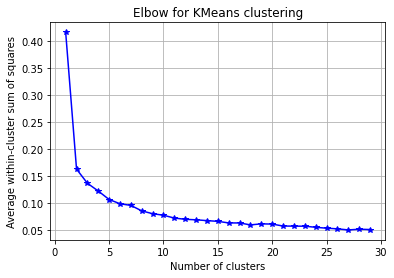

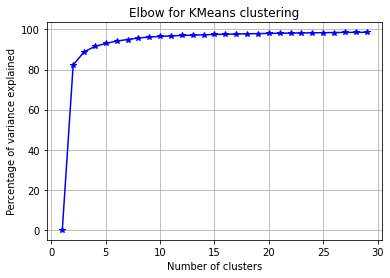

In [ ]:
elbow(test, range(1,30))

In [ ]:
#Calculating the silhouette score

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(test)
    #report average Silhouette score
    silhouette_avg = silhouette_score(test, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.868234403375073
For n_clusters =3, the average silhouette_score is :0.8102728023562001
For n_clusters =4, the average silhouette_score is :0.7226718269659637
For n_clusters =5, the average silhouette_score is :0.4301881549571966
For n_clusters =6, the average silhouette_score is :0.40726877207594026
For n_clusters =7, the average silhouette_score is :0.4145368063787671
For n_clusters =8, the average silhouette_score is :0.44264652248658853
For n_clusters =9, the average silhouette_score is :0.4264024415328442
For n_clusters =10, the average silhouette_score is :0.41927419812796723


In [ ]:
#Running k-means with 2 clusters
km = KMeans(n_clusters=2)
km.fit(test)
res=km.predict(test)
print('With',2,'clusters, sum of squared errors =',km.inertia_,'\n')

With 2 clusters, sum of squared errors = 128.4717631127982 



In [ ]:
#Fetching the GEOIDs with predicted labels
clustering_data['labels'] = pd.Series(res)
clustering_data['geo_id'] = clustering_data_labels
clustering_data.head()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,labels
0,36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8,0.0
1,36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0,0.0
2,36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9,0.0
3,36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0,0.0
4,36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,1.6,-2.1,6.2,16.1,0.5,1.5,2.5,0.0


In [ ]:
#Merging with spatial data for plotting
clustering_spatial_data = spatial_data.merge(clustering_data, how='inner',left_on='GEOID',right_on='geo_id')
clustering_spatial_data.shape

(1897, 66)

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


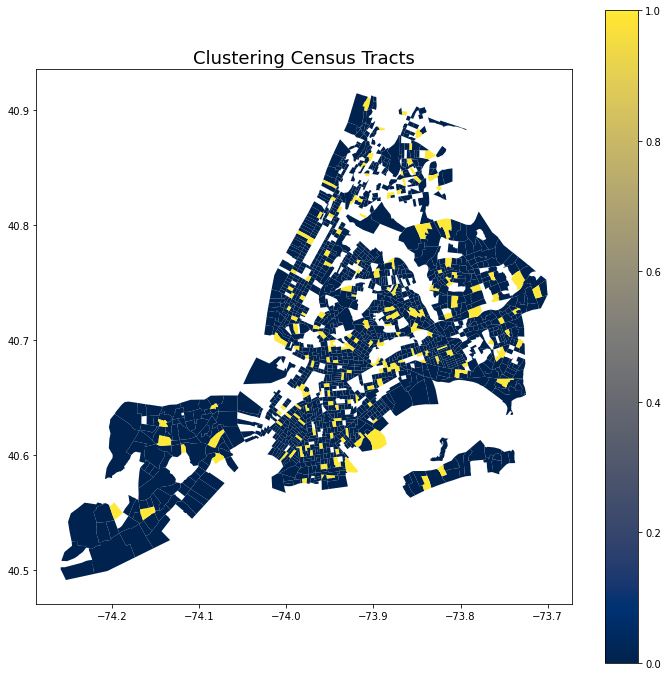

In [ ]:
#Plotting the cluster labels
f, ax = plt.subplots(1, figsize=(12, 12))

ax.set_title('Clustering Census Tracts', fontsize=18)
clustering_spatial_data.plot(axes=ax, column='labels', legend = True, cmap='cividis')

In [ ]:
#Visualising info in each cluster 
clustering_data[clustering_data['labels']==0].describe()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,labels
count,1.489000e+03,1489.00000,1.489000e+03,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.0
mean,3.605876e+10,7807.54589,3.947023e+05,535.404150,-0.005192,0.002750,-1324.057085,1017.209537,967.146407,9390.108126,-210.396911,-81.886501,130.443922,-17.572733,-20.148825,-1.807723,0.718805,-2.477502,-16.429349,0.569846,0.0
std,2.304439e+07,43982.90133,3.586174e+05,607.200457,0.258657,0.126834,2506.429104,2484.460310,794.187490,31912.649130,1434.685346,486.389246,746.201717,127.892353,128.816576,9.055410,41.253871,37.138063,126.021067,8.285638,0.0
min,3.600500e+10,-182498.33000,-7.845111e+05,-1233.410000,-0.994939,-0.366742,-15528.000000,-8427.000000,-4558.000000,-146774.000000,-10562.000000,-9923.000000,-4668.000000,-1047.100000,-1019.800000,-37.000000,-100.000000,-100.000000,-1002.800000,-36.800000,0.0
25%,3.604704e+10,-16469.77000,1.900330e+05,176.810000,-0.159632,-0.082281,-2893.000000,-340.000000,465.000000,-6519.000000,-1008.000000,-169.000000,-216.000000,-8.100000,-6.500000,-5.900000,-11.700000,-6.400000,0.000000,-3.000000,0.0
50%,3.606101e+10,6620.63000,3.650430e+05,561.720000,-0.001766,-0.006264,-1328.000000,999.000000,793.000000,3984.000000,-350.000000,-49.000000,61.000000,-0.900000,-3.100000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,3.608105e+10,32001.03000,5.479680e+05,864.130000,0.150698,0.065091,142.000000,2336.000000,1311.000000,16156.000000,458.000000,42.000000,429.000000,4.800000,0.000000,2.900000,12.000000,6.400000,0.000000,3.900000,0.0
max,3.608503e+10,211301.09000,1.971222e+06,2955.400000,0.939009,0.614329,10655.000000,13436.000000,5632.000000,181046.000000,7994.000000,2154.000000,4676.000000,100.000000,27.400000,37.200000,100.000000,100.000000,100.000000,38.500000,0.0


In [ ]:
#Visualising info in each cluster 
clustering_data[clustering_data['labels']==1].describe()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,labels
count,1.890000e+02,189.000000,1.890000e+02,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.0
mean,3.605575e+10,2302.244286,3.484971e+05,504.261111,-0.032513,-0.000037,-1135.063492,977.497354,917.497354,5005.873016,-117.010582,-67.142857,146.391534,-5.998942,-8.248677,-0.324339,5.886243,1.458201,-6.117989,1.728042,1.0
std,2.455342e+07,45286.900576,3.338755e+05,603.490782,0.262041,0.129909,2463.141768,2573.898710,950.319854,30596.900448,1441.624335,286.002875,772.839504,75.312836,73.812979,9.300917,42.823253,35.152072,72.800003,9.057664,0.0
min,3.600500e+10,-224195.930000,-5.329791e+05,-1257.740000,-0.782410,-0.315304,-6279.000000,-6171.000000,-2950.000000,-188385.000000,-3151.000000,-1514.000000,-1386.000000,-1015.500000,-1014.400000,-32.500000,-97.200000,-96.700000,-999.000000,-39.900000,1.0
25%,3.604704e+10,-21354.230000,1.534680e+05,180.860000,-0.195317,-0.081502,-2829.000000,-270.000000,449.000000,-6485.000000,-985.000000,-181.000000,-234.000000,-6.900000,-6.600000,-4.200000,-7.100000,-3.700000,0.000000,-3.200000,1.0
50%,3.604712e+10,4226.280000,3.395950e+05,540.080000,-0.013592,-0.012032,-1600.000000,964.000000,783.000000,2552.000000,-342.000000,-40.000000,-2.000000,-1.000000,-2.600000,0.000000,0.300000,0.000000,0.000000,0.100000,1.0
75%,3.608105e+10,28406.610000,5.307120e+05,755.490000,0.136464,0.074599,409.000000,2364.000000,1261.000000,12650.000000,693.000000,64.000000,474.000000,4.600000,0.200000,4.400000,18.200000,6.200000,0.000000,5.800000,1.0
max,3.608502e+10,139148.310000,1.482176e+06,2831.670000,0.678886,0.373300,7169.000000,9823.000000,6429.000000,113657.000000,6329.000000,1158.000000,4480.000000,49.800000,19.500000,22.900000,100.000000,96.800000,18.200000,28.300000,1.0


As per the clustering analysis, the ideal number of clusters are 2. The two types of tracts that we got had major differences in the change in median income, educational attainment, the population living in poverty, unemployed population, minority race population composition, housing in structures with 10 or more units and change in mobile units. For tracts where incomes significantly rose within the 5 year period, it was also observed that people living in structures with 10 or more units declined, indicating a possibility of ongoing displacement within tracts that have gentrified

## Spatial Engineering


In [ ]:
#Getting list of NYC based counties
NYC_COUNTIES = [
    "005", # Bronx
    "047", # Kings (Brooklyn)
    "061", # New York County (Manhattan)
    "081", # Queens
    "085", # Richmond (Staten Island)
]

In [ ]:
#Loading spatial data
spatial_data = gpd.read_file('tl_2019_36_tract.shp')
spatial_data['GEOID'] = spatial_data['GEOID'].astype(int)
spatial_data= spatial_data[spatial_data['COUNTYFP'].isin(NYC_COUNTIES)]
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712..."
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713..."
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711..."
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743..."
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714..."


In [ ]:
#Calculating queen weights for each GeoID (census tract)
w = Queen.from_dataframe(spatial_data,idVariable='GEOID')
w.transform = 'R'

('WARNING: ', 36061000100, ' is an island (no neighbors)')


/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 36061000100.
  warnings.warn(message)


In [ ]:
#Merging spatial data with tract demographic info
spatial_data = spatial_data.merge(df, how='inner',left_on='GEOID',right_on='geo_id')
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_edu_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2012_2011_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,NaN,-0.435488,NaN,3215,-1636,-30,76.0,846,38,NaN,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,NaN,610,-39,3,10250.0,-314,-323,NaN,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,NaN,-5605,1664,132,2394.0,-1033,63,NaN,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743...",36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,NaN,1041,-1237,211,9697.0,383,117,NaN,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714...",36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,NaN,3374,288,20,4391.0,1680,-3,NaN,1.6,-2.1,6.2,16.1,0.5,1.5,2.5


In [ ]:
#Checking for null values
spatial_data.isnull().sum(axis = 0)

In [ ]:
#Dropping education since all values are null
spatial_data = spatial_data.drop(columns='2012_2011_edu_dist')
spatial_data = spatial_data.drop(columns='2012_2011_bachelors_degree')

In [ ]:
#Fill NAs with 0 for spatial lag calculations
spatial_data = spatial_data.fillna(999)

In [ ]:
spatial_data.shape

(2167, 43)

In [ ]:
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,999.00,-0.435488,3215,-1636,-30,76.0,846,38,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,610,-39,3,10250.0,-314,-323,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,-5605,1664,132,2394.0,-1033,63,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743...",36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,1041,-1237,211,9697.0,383,117,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714...",36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,3374,288,20,4391.0,1680,-3,1.6,-2.1,6.2,16.1,0.5,1.5,2.5


In [ ]:
#Loading data for gentrification labels (dependent variable)
gentrification_data = pd.read_csv('/content/gentrification_13_18.csv')
gentrification_data = gentrification_data.drop(columns=['Unnamed: 0'])
gentrification_data = gentrification_data.rename(columns={'geo_id':'GEOID'})
gentrification_data.head()

,GEOID,total_pop_18,white_pop_18,black_pop_18,asian_pop_18,hispanic_pop_18,amerindian_pop_18,other_race_pop_18,two_or_more_races_pop_18,median_income_18,median_home_value_18,median_rent_18,bachelors_degree_18,total_pop_13,white_pop_13,black_pop_13,asian_pop_13,hispanic_pop_13,amerindian_pop_13,other_race_pop_13,two_or_more_races_pop_13,median_income_13,median_rent_13,median_home_value_13,bachelors_degree_13,total_pop_10,white_pop_10,black_pop_10,asian_pop_10,hispanic_pop_10,amerindian_pop_10,other_race_pop_10,two_or_more_races_pop_10,median_income_10,median_rent_10,median_home_value_10,bachelors_degree_10,total_population00,median_income00,median_home_value00,educational_attainment_00,white_alone00,black_alone00,native00,asian00,native_hawaiian_pacific_islander00,hispanic_or_latino00,educational_attainment_pct,educational_attainment_pct13,educational_attainment_change,home_pct_change,has_pop_500+_2013,has_pop_500+_2018,median_40th_home_2013,median_40th_income_2013,educational_is_upper3rd,median_home_higher,median_home_top_third,gentrified,pct_white_alone_change,pct_white_alone_2018,pct_black_alone_change,pct_black_alone_2018,pct_asian_alone_change,pct_asian_alone_2018,pct_hispanic_alone_change,pct_hispanic_alone_2018,low_population,eligible_for_gentrification,not_eligible_highpop
0,36005050400,222,0,25,3,194,0,0,0,NaN,NaN,725.0,0,33.0,14.0,7.0,0.0,12.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,5.000000,NaN,0.0000,0.000000,2.000000,0.000000,0.0,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,NaN,False,False,False,False,False,False,False,False,-42.424242,0.000000,-9.950860,11.261261,1.351351,1.351351,51.023751,87.387387,True,False,False
1,36081005000,101,9,0,0,92,0,0,0,NaN,NaN,1571.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,103.457771,27411.00086,224999.9975,23.647491,10.838433,5.911873,0.0,30.544676,0.0,56.162788,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False,False,NaN,8.910891,NaN,0.000000,NaN,0.000000,NaN,91.089109,True,False,False
2,36005043500,361,15,153,0,87,101,0,5,NaN,NaN,870.0,10,16.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,77.0,0.0,21.0,0.0,56.0,0.0,0.0,0.0,17604.0,NaN,312500.0,NaN,65.437142,80487.99663,225000.0057,0.000000,2.845093,18.967287,0.0,0.000000,0.0,36.986210,2.770083,0.000000,2.770083,NaN,False,False,False,False,False,False,False,False,4.155125,4.155125,-57.617729,42.382271,0.000000,0.000000,24.099723,24.099723,True,False,False
3,36081056100,60,35,0,17,8,0,0,0,100000.0,425000.0,NaN,12,146.0,21.0,40.0,20.0,55.0,0.0,0.0,10.0,112000.0,1750.0,312500.0,39.0,55.0,9.0,0.0,0.0,46.0,0.0,0.0,0.0,104875.0,1238.0,NaN,NaN,7.000000,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.0,7.000000,20.000000,26.712329,-6.712329,0.280000,False,False,True,False,False,True,True,False,43.949772,58.333333,-27.397260,0.000000,14.634703,28.333333,-24.337900,13.333333,True,False,False
4,36081011400,1382,176,209,341,627,0,4,25,49242.0,591900.0,1305.0,17,883.0,137.0,67.0,33.0,583.0,10.0,0.0,53.0,44464.0,1099.0,448700.0,140.0,984.0,82.0,49.0,148.0,705.0,0.0,0.0,0.0,50556.0,1026.0,458500.0,NaN,1120.000000,28571.00000,246400.0000,86.000000,358.000000,140.000000,13.0,105.000000,0.0,464.000000,1.230101,15.855040,-14.624938,0.239144,True,True,False,True,False,True,True,False,-2.780122,12.735166,7.535241,15.123010,20.937126,24.674385,-20.655885,45.369030,False,False,True


In [ ]:
#Merging the two datasets together
spatial_data = spatial_data.merge(gentrification_data[['GEOID','gentrified']], on = 'GEOID',how='left')

In [ ]:
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrified
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,999.00,-0.435488,3215,-1636,-30,76.0,846,38,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8,False
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,610,-39,3,10250.0,-314,-323,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0,False
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,-5605,1664,132,2394.0,-1033,63,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9,True
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743...",36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,1041,-1237,211,9697.0,383,117,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0,False
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714...",36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,3374,288,20,4391.0,1680,-3,1.6,-2.1,6.2,16.1,0.5,1.5,2.5,False


In [ ]:
#Assigning values 1 or 0 as gentrification labels
def f(row):
    if row['gentrified'] == False:
      val = 0
    elif row['gentrified'] == True:
      val = 1
    else:
      val = 2

    return val

spatial_data['gentrification_label'] = spatial_data.apply(f, axis=1)

In [ ]:
spatial_data.isnull().sum(axis = 0)

STATEFP                                                0
COUNTYFP                                               0
TRACTCE                                                0
GEOID                                                  0
NAME                                                   0
NAMELSAD                                               0
MTFCC                                                  0
FUNCSTAT                                               0
ALAND                                                  0
AWATER                                                 0
INTPTLAT                                               0
INTPTLON                                               0
geometry                                               0
geo_id                                                 0
2017_2012_median_income                                0
2017_2012_owner_occupied_housing_units_median_value    0
2017_2012_median_rent                                  0
2017_2012_income_dist          

In [ ]:
#Calculating spatial weights for neighboring census tracts
import libpysal as lps

spatial_data['lagged_spatial_income'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_median_income'])
spatial_data['lagged_home_value'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_owner_occupied_housing_units_median_value'])
spatial_data['lagged_spatial_rent'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_median_rent'])
spatial_data['lagged_income_dist'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_income_dist'])
spatial_data['lagged_white_pop'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_white_pop'])
spatial_data['lagged_other_races'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_other_races'])
#spatial_data['lagged_edu_dist'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_edu_dist'])
spatial_data['lagged_public_commute'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_commuters_by_public_transportation'])
spatial_data['lagged_income_per_capita'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_income_per_capita'])
spatial_data['lagged_housing_units'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_housing_units'])
spatial_data['lagged_vacant_housing_units'] = lps.weights.lag_spatial(w, spatial_data['2012_2011_vacant_housing_units'])

In [ ]:
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrified,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,999.00,-0.435488,3215,-1636,-30,76.0,846,38,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8,False,0,-32822.854000,-105452.782000,-299.944000,-0.236056,-62.200000,-561.000000,-104.600000,-9491.200000,480.600000,380.800000
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,610,-39,3,10250.0,-314,-323,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0,False,0,-9065.913333,-77619.500000,57.618333,-0.076920,-105.666667,-158.833333,27.333333,-4337.833333,57.333333,20.666667
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,-5605,1664,132,2394.0,-1033,63,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9,True,1,-4140.120000,-11113.857143,107.161429,-0.127328,-912.142857,-472.714286,11.285714,-3174.000000,-493.714286,-41.428571
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743...",36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,1041,-1237,211,9697.0,383,117,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0,False,0,-10884.158571,-21295.714286,326.705714,-0.109194,-808.857143,84.571429,33.714286,-5153.428571,-176.285714,11.571429
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714...",36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,3374,288,20,4391.0,1680,-3,1.6,-2.1,6.2,16.1,0.5,1.5,2.5,False,0,26428.710000,106350.227143,197.973571,0.016150,458.571429,-139.428571,104.785714,18682.857143,330.500000,83.857143


In [ ]:
#spatial_data = spatial_data[spatial_data['gentrification_label']!= 2]
#spatial_data['gentrification_label'].value_counts()

In [ ]:
spatial_data['gentrification_label'].value_counts()

0    2122
1      45
Name: gentrification_label, dtype: int64

In [ ]:
#spatial_data = spatial_data[spatial_data['gentrification_label']!=999]

Without dividing imbalanced classes

In [ ]:
#Running models as is without balancing the datasets to include equal proportions of each classes for better training setting
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_auc_ovr
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing

spatial_data_training = spatial_data

#Getting modelling features
features = ['2017_2012_median_income','2017_2012_owner_occupied_housing_units_median_value','2017_2012_median_rent','2017_2012_income_dist',
            '2017_2012_edu_dist','2017_2012_white_pop','2017_2012_other_races','2017_2012_commuters_by_public_transportation',
            '2017_2012_income_per_capita','2017_2012_housing_units','2017_2012_vacant_housing_units','2017_2012_bachelors_degree',
            '2018_2014_EP_POV','2018_2014_EP_UNEMP','2018_2014_EP_SNGPNT','2018_2014_EP_MINRTY','2018_2014_EP_MUNIT','2018_2014_EP_MOBILE',
            '2018_2014_EP_CROWD','lagged_spatial_income','lagged_home_value','lagged_spatial_rent','lagged_income_dist','lagged_white_pop',
            'lagged_other_races','lagged_public_commute','lagged_income_per_capita','lagged_housing_units','lagged_vacant_housing_units']

#Converting into train-test
X = spatial_data_training[features]
y = spatial_data_training['gentrification_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 999)

#Scaling the dataset
mu=X_train.iloc[:,:].mean()
sigma=X_train.iloc[::].std()

X_train.iloc[:,:]=(X_train.iloc[:,:]-mu)/sigma
X_test.iloc[:,:]=(X_test.iloc[:,:]-mu)/sigma

#Getting RF Params
param_grid ={"max_depth":[x for x in range(1,25,1)]} 

fr = RandomForestClassifier()
gr = GridSearchCV(fr,param_grid=param_grid,cv=5)
rs=gr.fit(X_train,y_train) 

rf_predictions = rs.predict(X_test)
rf_probs = rs.predict_proba(X_test)[:, 1]

print ("Random Forest Train Accuracy Baseline:", accuracy_score(y_train, rs.predict(X_train)))
print ("Random Forest Test Accuracy Baselsine:", accuracy_score(y_test, rs.predict(X_test)))

#Calculating roc,precision,recall - we are more interested in the recall prediction - that will be our actual prediciton score 
#Recall tells the probability of classifying gentrification correctly
roc_value = roc_auc_score(y_test, rf_probs)
precision = precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)


print('The roc is {}'.format(roc_value))
print('The precision is {}'.format(precision))
print('The recall is {}'.format(recall))
print('The F1 Score is {}'.format(f1))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Random Forest Train Accuracy Baseline: 0.9821899736147758
Random Forest Test Accuracy Baselsine: 0.9723502304147466
The roc is 0.6696945760926803
The precision is 0.0
The recall is 0.0
The F1 Score is 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Getting confusion matrix - bad results
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,rf_predictions))

[[633   0]
 [ 18   0]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       633
           1       0.00      0.00      0.00        18

    accuracy                           0.97       651
   macro avg       0.49      0.50      0.49       651
weighted avg       0.95      0.97      0.96       651



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,15, 20, None],
    'min_samples_leaf': [1, 10, 20, 50, 100],
    'min_samples_split': [2, 30, 40],
}
param_grid

{'bootstrap': [True],
 'max_depth': [10, 15, 20, None],
 'min_samples_leaf': [1, 10, 20, 50, 100],
 'min_samples_split': [2, 30, 40]}

In [ ]:
# Create a based model
rfc_gs = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc_gs, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.best_params_
#still kind of out of the box

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
optimal_param_grid = {
    'bootstrap': [True],
    'max_depth': [10], #setting this so as not to create a tree that's too big
    #'max_features': [2, 3, 4, 10],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    #'n_estimators': [17]
}

In [ ]:
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = optimal_param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
rfc_pred_gs = grid_search.predict(X_test)

y_pred_gs =  grid_search.predict(X_test)
print ("Random Forest Train Accuracy Baseline After Grid Search:", accuracy_score(y_train, grid_search.predict(X_train)))
print ("Random Forest Test Accuracy Baseline After Grid Search:", accuracy_score(y_test, grid_search.predict(X_test)))
#print('Accuracy of random forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))
roc_value = roc_auc_score(y_test, rfc_pred_gs)
precision = precision_score(y_test, rfc_pred_gs)
recall = recall_score(y_test, rfc_pred_gs)


print('The roc is {}'.format(roc_value))
print('The precision is {}'.format(precision))
print('The recall is {}'.format(recall))

Random Forest Train Accuracy Baseline After Grid Search: 0.9953825857519789
Random Forest Test Accuracy Baseline After Grid Search: 0.9723502304147466
The roc is 0.5
The precision is 0.0
The recall is 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Correctly predicted classes for each gentrification = 0 and 1
from sklearn.metrics import confusion_matrix
print('Confusion matrix\n',confusion_matrix(y_test,rfc_pred_gs))

Confusion matrix
 [[633   0]
 [ 18   0]]


In [ ]:
#Feature Importance (Gini importance)
rf = RandomForestClassifier(max_depth=4)
rf.fit(X_train,y_train)

pd.DataFrame({"importance":rf.feature_importances_},index=X_train.columns).sort_values(by=["importance"],ascending=False)[:10]

,importance
lagged_white_pop,0.122931
2017_2012_median_income,0.069346
2018_2014_EP_MINRTY,0.067867
2018_2014_EP_SNGPNT,0.062455
lagged_housing_units,0.057625
2018_2014_EP_UNEMP,0.055019
2018_2014_EP_CROWD,0.053244
2018_2014_EP_MUNIT,0.049293
2018_2014_EP_POV,0.048763
lagged_public_commute,0.042578


Dividing imbalanced classes

In [ ]:
#Running stratified k fold sampling
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

skf.get_n_splits(X, y)

5

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.metrics import f1_score

i=1
roc_score =[]
precision_val = []
recall_val = []
f1_val = []

for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    xtr,xvl = X[train_index],X[test_index]
    ytr,yvl = y[train_index],y[test_index]

    param_grid ={"max_depth":[x for x in range(1,25,1)]} 

    fr = RandomForestClassifier()
    gr = GridSearchCV(fr,param_grid=param_grid,cv=5)

    rs=gr.fit(xtr,ytr) 

    rf_predictions = rs.predict(xvl)
    rf_probs = rs.predict_proba(xvl)[:, 1]

    # Calculate roc auc
    roc_value = roc_auc_score(yvl, rf_probs)
    print('ROC AUC score:',roc_value)
    roc_score.append(roc_value) 
    precision = precision_score(yvl, rf_predictions)
    print('Precision score:',precision)
    precision_val.append(precision) 
    recall = recall_score(yvl, rf_predictions)
    print('Recall score:',recall)
    recall_val.append(recall) 
    f1 = f1_score(yvl,rf_predictions)
    print('F1 Score:',f1)
    f1_val.append(f1) 
    i+=1

1 of KFold 5
ROC AUC score: 0.6620915032679738
Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.7184313725490196
Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.6171383647798742
Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.6713836477987422
Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.7984800838574424
Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('\nMean ROC Score',np.mean(roc_score))
print('\nMean Precision Score',np.mean(precision))
print('\nMean Recall Score',np.mean(recall))
print('\nMean F1 Score',np.mean(f1))


Mean ROC Score 0.6935049944506104

Mean Precision Score 0.0

Mean Recall Score 0.0

Mean F1 Score 0.0


In [ ]:
spatial_data[spatial_data['gentrification_label']==1].describe()

,GEOID,ALAND,AWATER,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units
count,4.500000e+01,45.000000,4.500000e+01,4.500000e+01,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,3.604526e+10,173389.600000,6.250704e+04,3.604526e+10,-25561.604667,239371.044444,267.667111,-0.137571,-0.016405,-2702.066667,2646.355556,1412.444444,-5001.000000,-186.111111,-98.266667,64.866667,9486.899778,-18855.777778,223.807556,0.048593,525.288889,-288.20000,-55.933333,392.622222,77.088889,-16.777778,-40.406667,-46.600000,1.704444,8.506667,15.442222,-45.611111,3.082222,1.0,6965.354836,-4297.513865,120.239155,-0.037193,201.747928,-36.294312,-37.814841,704.269021,44.979480,4.704612
std,2.488828e+07,95491.779792,3.108736e+05,2.488828e+07,39339.078755,215201.669974,457.809979,0.255833,0.081217,2331.348209,2654.744956,943.400945,15137.567805,1368.359157,203.329826,625.965712,46278.956165,214957.348557,462.641566,0.302299,2789.341219,1726.01573,181.977196,18373.152176,1231.970591,410.895800,214.660097,210.744062,11.134711,55.458963,48.129411,208.011025,12.070160,0.0,15119.484216,92951.219679,218.938735,0.115475,1382.462742,1014.727399,172.436585,7983.707223,541.757017,122.558515
min,3.600500e+10,60659.000000,0.000000e+00,3.600500e+10,-180323.470000,-387555.000000,-702.420000,-0.994939,-0.163895,-9134.000000,-2127.000000,139.000000,-43277.000000,-2432.000000,-688.000000,-1306.000000,-100497.470000,-693409.000000,-492.380000,-0.780872,-5605.000000,-4915.00000,-675.000000,-55091.000000,-3370.000000,-2147.000000,-1030.300000,-1018.400000,-24.400000,-100.000000,-89.300000,-999.000000,-23.500000,1.0,-35272.731667,-274362.333333,-467.211667,-0.290281,-2387.000000,-2035.125000,-389.666667,-18443.833333,-1082.500000,-304.833333
25%,3.604701e+10,138489.000000,0.000000e+00,3.604701e+10,-41225.080000,58911.000000,-4.660000,-0.253671,-0.083770,-4072.000000,855.000000,771.000000,-13885.000000,-1057.000000,-166.000000,-299.000000,-18451.610000,-74668.000000,-96.250000,-0.077218,-1672.000000,-1178.00000,-63.000000,-7872.000000,-628.000000,-107.000000,-2.500000,-5.400000,-4.100000,-6.300000,-3.400000,-0.500000,-2.800000,1.0,-2940.041250,-54139.857143,-7.927143,-0.123820,-871.166667,-670.800000,-121.250000,-3221.600000,-300.400000,-67.666667
50%,3.604704e+10,162809.000000,0.000000e+00,3.604704e+10,-16779.240000,283868.000000,293.600000,-0.087291,-0.025277,-2830.000000,2694.000000,1233.000000,-4797.000000,-417.000000,-104.000000,-5.000000,5646.730000,7598.000000,153.350000,0.025440,120.000000,43.00000,-4.000000,2394.000000,214.000000,47.000000,1.800000,-2.700000,0.800000,2.600000,8.800000,0.000000,2.200000,1.0,7161.367500,9510.018000,135.184000,-0.043934,110.888889,-76.666667,-39.333333,1613.666667,6.25

In [ ]:
spatial_data[spatial_data['gentrification_label']==0].describe()

,GEOID,ALAND,AWATER,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units
count,2.122000e+03,2.122000e+03,2.122000e+03,2.122000e+03,2122.000000,2.122000e+03,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2.122000e+03,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.0,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000
mean,3.605496e+10,3.629501e+05,2.035010e+05,3.605496e+10,4025.713845,3.362158e+05,512.013332,-0.001365,0.001580,-1437.028746,1065.043355,931.090481,6868.624882,-245.123940,-84.986334,74.488219,5779.955490,1.469970e+04,118.539496,-0.006827,-14.813855,45.690386,-0.073044,410.140905,12.662582,6.273798,-13.846418,-16.357116,-0.729972,3.698539,-0.126579,-13.668803,1.286239,0.0,5614.101850,13838.236485,118.659859,-0.005721,1.999738,31.622552,-1.698191,333.242865,19.364391,11.276280
std,2.593875e+07,7.289150e+05,3.266417e+06,2.593875e+07,43918.985660,3.566432e+05,619.109446,0.283252,0.130890,2428.820260,2671.274095,829.285916,30401.386180,1445.183007,430.887624,737.263148,38846.746932,2.279045e+05,493.573754,0.277073,2506.219922,2164.416568,333.283214,20944.671895,1108.297924,468.521603,118.323347,118.584238,23.677135,49.321332,44.805811,118.389144,23.261441,0.0,16233.835495,96061.057321,209.447278,0.112344,1037.331779,916.540555,133.947939,8569.094308,448.921762,188.177646
min,3.600500e+10,0.000000e+00,0.000000e+00,3.600500e+10,-224195.930000,-8.776920e+05,-1664.230000,-1.458625,-0.569676,-15528.000000,-8427.000000,-4558.000000,-188385.000000,-10562.000000,-9923.000000,-4668.000000,-218291.040000,-9.161800e+05,-1757.930000,-1.286707,-9070.000000,-13379.000000,-2471.000000,-194576.000000,-4314.000000,-3121.000000,-1047.100000,-1019.800000,-37.000000,-100.000000,-100.000000,-1026.200000,-40.600000,0.0,-69352.656000,-322603.600000,-855.530000,-0.430144,-4056.500000,-4899.500000,-667.400000,-52159.000000,-1864.666667,-695.857143
25%,3.604703e+10,1.568535e+05,0.000000e+00,3.604703e+10,-20850.250000,8.007550e+04,132.867500,-0.166674,-0.083179,-2926.000000,-415.750000,418.500000,-7749.000000,-1049.500000,-173.000000,-275.750000,-14281.142500,-8.123175e+04,-174.517500,-0.160288,-1662.500000,-965.750000,-42.000000,-9068.250000,-673.750000,-122.000000,-7.900000,-6.400000,-5.400000,-10.800000,-5.800000,-0.100000,-3.000000,0.0,-4674.138083,-42973.718750,-15.985714,-0.078041,-694.466667,-531.166667,-59.750000,-4506.491071,-263.964286,-70.187500
50%,3.604712e+10,1.857560e+05,0.000000e+00,3.604712e+10,1777.195000,3.174345e+05,550.370000,0.008867,-0.006679,-1510.000000,993.000000,769.000000,1643.000000,-357.500000,-54.000000,23.000000,4624.785000,9.427500e+03,100.495000,-0.007168,-98.500000,16.000000,0.000000,202.000000,1.000000,-2.500000,-0.900000,-2.900000,-0.700000,0.200000,0.000000,0.000000,0.100000,0.0,5602.325625,12656

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


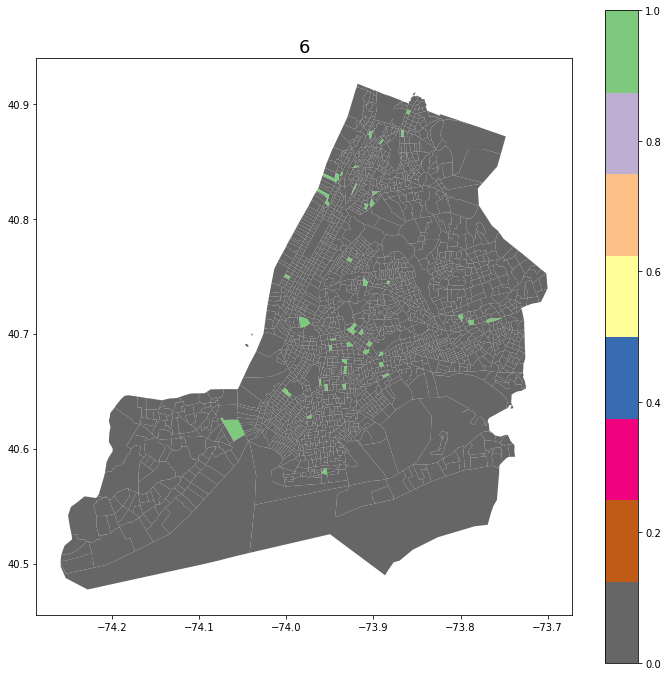

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 12))

ax.set_title(i, fontsize=18)
spatial_data.plot(axes=ax, column='gentrification_label', legend = True, cmap='Accent_r')

#supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_s...


Only 45 tracts predicted as gentrified and the important features seem to suggest that spatial lags of white population (proportion of white population amongst neightboring tracts during the start of the 5 yr period), proportion of single parent households, proportion of white population and vacant houses determine whether a tract has gentrified. However the results are skewed, with bad sensitivity and specificity scores. 

### Using SVM

In [ ]:
from sklearn import svm
# Let's first try a linear model with parameter value C=1.
clf = svm.SVC(kernel='linear',C=1)
clf.fit(X_train, y_train)
correct=1.0*(clf.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)

y_pred = clf.predict(X_test)

print("Out of sample, linear model successfully predicts {} percent of the data".format((correct)*100))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Out of sample, linear model successfully predicts 96.7741935483871 percent of the data
Accuracy: 0.967741935483871
Precision: 0.2
Recall: 0.05555555555555555


### Using Logistic Regression

In [ ]:
#Balacing the dataset and scaling parameters
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

mu=X_train.iloc[:,:].mean()
sigma=X_train.iloc[::].std()

X_train.iloc[:,:]=(X_train.iloc[:,:]-mu)/sigma
X_test.iloc[:,:]=(X_test.iloc[:,:]-mu)/sigma


os_data_X,os_data_y = os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)

os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  2956
Number of no subscription in oversampled data 1478
Number of subscription 1478
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [ ]:
#Getting important features for the model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False  True  True False  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True False
 False False False  True False]
[ 1  9 10  1  1  2  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  7
  5  4  6  1  8]


In [ ]:
X_train

,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units
1584,-0.126063,-0.217649,-0.064830,-0.238547,0.404306,1.038146,-0.178151,-0.139165,-0.067441,0.682794,0.404343,0.796061,0.089767,0.037685,-0.362858,-0.223636,0.050089,0.123856,-0.310912,0.578386,0.234874,-0.480644,-0.586763,0.734663,-0.238007,0.142220,0.824194,0.504690,0.684501
841,0.814999,2.436140,1.264471,1.112115,-0.517496,-0.924075,0.399200,0.191082,0.367036,-0.672107,-0.358020,0.638036,0.065896,0.050973,-0.337327,-0.260778,0.075641,0.123073,-0.111503,0.085110,0.736498,0.453002,2.526144,-0.277023,-1.660874,-1.530767,-0.230948,-1.817108,-0.117301
905,-0.498732,0.043986,-0.423730,0.365160,0.672244,-0.327770,1.029576,0.524931,-0.232835,0.669039,0.870087,0.022284,0.125959,0.143994,0.238926,-0.084843,-0.067022,0.123073,0.128525,0.036118,-0.534194,-0.562704,-1.667566,0.537489,0.693942,-0.294534,-0.839170,-0.404448,-1.623540
728,2.341076,1.517726,1.845602,2.051014,2.138409,0.563402,-1.236071,1.086950,3.464088,0.338911,0.349703,1.831396,0.115948,0.131487,-0.184146,-0.700614,-0.030824,0.123073,-0.288755,-1.869941,-0.848047,0.554994,1.149764,0.247514,0.349243,-0.292683,-2.022532,0.366312,-0.103170
40,-0.599478,0.503787,-0.056898,-0.324299,-0.269897,-0.673150,-0.663541,-0.570286,-0.099444,-0.996734,-0.207108,-1.673760,0.062816,0.145557,-0.268031,-0.057475,0.131003,-0.158052,-0.008106,1.526988,1.105991,1.198794,0.721027,-0.218147,-0.107986,0.180466,1.064459,-0.533237,-0.761842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,-0.781334,0.529070,-0.906576,-1.134801,-0.106057,1.103854,-0.973538,0.856378,0.046969,0.481966,0.607293,0.488185,0.037405,0.091621,-0.264384,-1.435630,-0.011661,0.148131,-0.251828,1.688948,2.735373,2.621507,1.552073,-0.280109,0.137941,-0.880819,0.571153,-0.621478,-0.247303
1731,-3.229284,-2.365818,0.778701,-3.049719,-2.363604,0.866893,-1.303558,-1.050645,-0.230341,0.488844,0.976766,-0.830506,0.158300,0.093184,0.300928,-0.106346,-0.030824,0.123073,-0.281370,0.647211,1.549348,0.950275,0.967476,0.796924,-0.341748,-0.065053,0.988324,0.652062,0.022791
763,-1.570601,-0.943533,-1.846639,0.486916,0.041569,-0.018940,-1.082556,-1.110689,-0.284630,0.027352,0.578672,-0.429995,0.159070,0.107255,0.381166,1.412557,1.242497,0.123073,0.220844,0.428571,0.333968,0.091366,-0.251483,1.776732,-1.402089,-0.295767,0.032366,-0.028950,-0.183852
835,-0.129098,0.549136,-0.184985,-0.059043,-0.057972,-1.387730,-0.368747,0.063787,0.628085,-0.598516,0.219607,-0.168436,0.138279,0.131487,-0.074731,-0.391751,-0.030824,0.123073,-0.056112,-0.642407,1.140062,1.069154,0.390490,-2.180281,1.223831,0.303843,-1.213093,-1.358765,0.668547


In [ ]:
#Subsetting data
cols=['2017_2012_median_income', '2017_2012_white_pop','2017_2012_income_dist','2017_2012_edu_dist', '2017_2012_other_races', '2017_2012_commuters_by_public_transportation','2017_2012_income_per_capita', '2017_2012_housing_units', '2017_2012_vacant_housing_units', 
      '2017_2012_bachelors_degree', '2018_2014_EP_POV', '2018_2014_EP_UNEMP', '2018_2014_EP_SNGPNT', '2018_2014_EP_MUNIT', '2018_2014_EP_MOBILE','2018_2014_EP_CROWD','lagged_spatial_income', 'lagged_home_value','lagged_spatial_rent', 'lagged_income_dist','lagged_housing_units']

Xn=os_data_X[cols]
yn=os_data_y['y']

In [ ]:
#Running logistic regression
import statsmodels.api as sm
logit_model=sm.Logit(yn,Xn)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.528533
         Iterations 6
                                       Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.237      
Dependent Variable:           y                        AIC:                      3166.6855  
Date:                         2020-07-15 23:07         BIC:                      3292.5089  
No. Observations:             2956                     Log-Likelihood:           -1562.3    
Df Model:                     20                       LL-Null:                  -2048.9    
Df Residuals:                 2935                     LLR p-value:              2.0185e-193
Converged:                    1.0000                   Scale:                    1.0000     
No. Iterations:               6.0000                                                        
--------------------------------------------------------------------------------------------
       

In [ ]:
#Subsetting columns with p-values less than 0.05

cols = ['2017_2012_median_income','2017_2012_income_dist','2017_2012_edu_dist','2017_2012_other_races','2017_2012_commuters_by_public_transportation',
        '2017_2012_income_per_capita','2017_2012_housing_units','2017_2012_vacant_housing_units','2017_2012_bachelors_degree',
        '2018_2014_EP_POV','2018_2014_EP_MUNIT','2018_2014_EP_MOBILE','lagged_spatial_income','lagged_home_value',
        'lagged_spatial_rent','lagged_income_dist']

Xn=os_data_X[cols]
yn=os_data_y['y']
logit_model=sm.Logit(yn,Xn)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.532894
         Iterations 6
                                       Results: Logit
Model:                       Logit                     Pseudo R-squared:          0.231      
Dependent Variable:          y                         AIC:                       3182.4693  
Date:                        2020-07-15 23:07          BIC:                       3278.3348  
No. Observations:            2956                      Log-Likelihood:            -1575.2    
Df Model:                    15                        LL-Null:                   -2048.9    
Df Residuals:                2940                      LLR p-value:               2.4873e-192
Converged:                   1.0000                    Scale:                     1.0000     
No. Iterations:              6.0000                                                          
--------------------------------------------------------------------------------------------

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(Xn_train, yn_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Getting accuracy score
y_pred = logreg.predict(Xn_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(Xn_test, yn_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(yn_test, y_pred)
print(confusion_matrix)

[[364 103]
 [ 59 361]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(yn_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       467
           1       0.78      0.86      0.82       420

    accuracy                           0.82       887
   macro avg       0.82      0.82      0.82       887
weighted avg       0.82      0.82      0.82       887



In [ ]:
len(y_pred)

887

In [ ]:
logreg.predict_proba(Xn_test)[:, 0] 

array([3.56620573e-01, 8.02331802e-01, 2.49300409e-01, 9.33716696e-01,
       2.30437889e-01, 8.65786071e-01, 9.58836848e-01, 7.68995665e-01,
       5.99964414e-01, 4.10367961e-01, 6.48191384e-01, 9.95770924e-01,
       9.33579407e-01, 9.38896701e-01, 2.41356668e-01, 4.01047260e-01,
       9.85646979e-01, 7.77361277e-01, 1.41198637e-01, 2.21297974e-01,
       1.90701575e-01, 4.41426118e-01, 1.51909408e-01, 8.78773059e-01,
       8.98188866e-01, 5.65216761e-01, 3.64071193e-02, 3.06562747e-01,
       4.93665825e-01, 9.86339740e-01, 9.99690257e-01, 9.22011529e-01,
       7.28395895e-01, 5.59068968e-01, 1.57889035e-01, 9.41094413e-01,
       1.51382691e-01, 2.39902711e-01, 9.43203724e-01, 1.05862319e-01,
       4.25397887e-02, 2.83053645e-01, 1.09008533e-01, 1.53036241e-01,
       5.31980404e-01, 4.82560672e-01, 5.61492286e-01, 1.49996384e-01,
       3.47341513e-01, 3.68953192e-01, 1.09823592e-01, 8.87555128e-01,
       6.15399480e-01, 2.18561197e-01, 4.63660423e-01, 6.35303363e-01,
      

In [ ]:
spatial_data.iloc[:,14:]

,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrified,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units
0,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,999.00,-0.435488,3215,-1636,-30,76.0,846,38,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8,False,0,-32822.854000,-105452.782000,-299.944000,-0.236056,-62.200000,-561.000000,-104.600000,-9491.200000,480.600000,380.800000
1,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,610,-39,3,10250.0,-314,-323,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0,False,0,-9065.913333,-77619.500000,57.618333,-0.076920,-105.666667,-158.833333,27.333333,-4337.833333,57.333333,20.666667
2,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,-5605,1664,132,2394.0,-1033,63,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9,True,1,-4140.120000,-11113.857143,107.161429,-0.127328,-912.142857,-472.714286,11.285714,-3174.000000,-493.714286,-41.428571
3,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,1041,-1237,211,9697.0,383,117,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0,False,0,-10884.158571,-21295.714286,326.705714,-0.109194,-808.857143,84.571429,33.714286,-5153.428571,-176.285714,11.571429
4,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,3374,288,20,4391.0,1680,-3,1.6,-2.1,6.2,16.1,0.5,1.5,2.5,False,0,26428.710000,106350.227143,197.973571,0.016150,458.571429,-139.428571,104.785714,18682.857143,330.500000,83.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,8334.77,196695.0,956.45,0.019043,-0.057887,-5209,4807,1993,8252.0,-207,-66,636.0,983.73,33743.0,-36.75,-0.077862,4673,367,-39,189.0,1956,168,-16.5,-2.3,-3.7,-41.3,-51.5,1.0,-4.6,False,0,50960.004000,162178.800000,640.528000,0.125059,1264.400000,-546.800000,-107.000000,11736.200000,-209.400000,-79.000000
2163,-46269.17,-46797.0,-799.90,0.025759,-0.115664,-2377,1679,556,-16560.0,-328,35,-450.0,88641.17,-258097.0,1115.90,0.198431,2295,-2545,-747,23396.0,-514,-85,0.2,0.8,2.3,-15.9,-92.3,18.6,1.4,False,0,6838.228000,47507.400000,118.398000,-0.123647,1320.400000,646.200000,31.200000,-1606.000000,551.200000,10.800000
2164,13181.24,49128.0,797.83,-0.180557,-0.056462,619,1531,1892,14697.0,1571,282,586.0,-1959.72,82580.0,94.41,0.122839,-1139,1456,13,-13468.0,-506,-89,-15.6,-8.8,-10.3,-83.3,-85.7,20.3,-7.7,False,0,30952.075000,-34220.750000,412.557500,-0.116195,1340.750000,-284.250000,-141.250000,7161.250000,198.000000,-27.500000
2165,20240.69,173223.0,533.25,0.336203,0.028264,-3181,555,182,5720.0,-1323,-138,-501.0,40128.59,82063.0,439.71,-0.507538,169,-431,169,10112.0,-635,-275,-5.1,-9.5,-2.3,-24.9,-84.5,5.7,-4.0,False,0,29931.758333,102532.833333,390.333333,0.248413,458.000000,570.833333,-131.833333,1491.500000,-232.333333,-49.166667


In [ ]:
spatial_data_pred = spatial_data[['geo_id','2017_2012_median_income','2017_2012_income_dist','2017_2012_edu_dist','2017_2012_other_races','2017_2012_commuters_by_public_transportation',
        '2017_2012_income_per_capita','2017_2012_housing_units','2017_2012_vacant_housing_units','2017_2012_bachelors_degree',
        '2018_2014_EP_POV','2018_2014_EP_MUNIT','2018_2014_EP_MOBILE','lagged_spatial_income','lagged_home_value',
        'lagged_spatial_rent','lagged_income_dist']]

In [ ]:
#Predicting for NYC 
spatial_data_pred.iloc[:,1:]=(spatial_data_pred.iloc[:,1:]-mu)/sigma
spatial_data_pred['prediction'] = logreg.predict_proba(spatial_data_pred.iloc[:,1:])[:, 1] 
spatial_data_pred.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,geo_id,2017_2012_median_income,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,prediction
0,36081044800,-0.323307,0.133102,-0.656659,0.540108,-0.324102,-0.482806,-0.382557,0.269043,-0.202493,-0.008026,-1.783239,0.123073,-2.360783,-1.227328,-1.969265,-2.054889,0.254595
1,36081045800,-0.268217,-0.332226,-0.619473,0.316880,-0.352924,-0.193835,-0.775960,0.014055,0.091760,-0.006486,-1.974876,0.368959,-0.912832,-0.938091,-0.288237,-0.645468,0.768312
2,36081046200,0.303780,-0.636892,0.401417,1.754509,1.315121,-0.384366,-0.269076,-0.243535,0.569922,0.089767,-1.891833,0.123073,-0.612612,-0.246980,-0.055317,-1.091915,0.896622
3,36081046300,-0.256014,-0.286405,-0.096444,0.005771,0.051778,-0.289165,-0.123269,-0.053595,0.087673,0.161380,-1.691679,0.132470,-1.023651,-0.352788,0.976839,-0.931310,0.473449
4,36081046400,0.455252,0.516261,0.201883,-0.117709,-0.659152,-0.199439,-1.333740,-0.139458,-1.278697,0.135969,-0.020178,0.134819,1.250515,0.973678,0.371623,0.178822,0.076820


In [ ]:
spatial_data['prediction'] = spatial_data_pred['prediction']

In [ ]:
spatial_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrified,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units,prediction
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",36081044800,-11203.74,495102.0,635.70,0.037868,-0.083222,-3409,2581,670,-8190.0,-778,31,-73.0,-7063.26,-26378.0,999.00,-0.435488,3215,-1636,-30,76.0,846,38,-17.1,-23.5,2.6,-93.3,-82.3,0.0,-21.8,False,0,-32822.854000,-105452.782000,-299.944000,-0.236056,-62.200000,-561.000000,-104.600000,-9491.200000,480.600000,380.800000,0.254595
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",36081045800,-8801.66,465607.0,625.05,-0.096485,-0.078431,-4580,1979,646,731.0,-1350,-67,143.0,42186.78,95493.0,380.35,-0.069210,610,-39,3,10250.0,-314,-323,-16.9,-11.9,-3.2,-94.4,-91.3,31.4,-23.0,False,0,-9065.913333,-77619.500000,57.618333,-0.076920,-105.666667,-158.833333,27.333333,-4337.833333,57.333333,20.666667,0.768312
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",36081046200,16139.15,391545.0,773.57,-0.184451,0.053082,-3183,5856,2035,-5151.0,-613,-166,494.0,-5846.39,-17271.0,187.93,0.124673,-5605,1664,132,2394.0,-1033,63,-4.4,-7.1,-4.1,-85.5,-87.4,0.0,-16.9,True,1,-4140.120000,-11113.857143,107.161429,-0.127328,-912.142857,-472.714286,11.285714,-3174.000000,-493.714286,-41.428571,0.896622
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743...",36081046300,-8269.56,311926.0,221.94,-0.083255,-0.011053,-1053,1140,983,-2212.0,-401,-93,140.0,24195.76,182994.0,466.52,-0.119574,1041,-1237,211,9697.0,383,117,4.9,0.7,3.4,-60.9,-78.0,1.2,-14.0,False,0,-10884.158571,-21295.714286,326.705714,-0.109194,-808.857143,84.571429,33.714286,-5153.428571,-176.285714,11.571429,0.473449
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714...",36081046400,22743.78,519311.0,831.68,0.148496,0.027378,-4709,807,391,558.0,-2161,-126,-863.0,4594.38,-107959.0,-389.90,0.011567,3374,288,20,4391.0,1680,-3,1.6,-2.1,6.2,16.1,0.5,1.5,2.5,False,0,26428.710000,106350.227143,197.973571,0.016150,458.571429,-139.428571,104.785714,18682.857143,330.500000,83.857143,0.076820


In [ ]:
spatial_data.to_csv('NY_Gentrification_Prediction.csv')

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


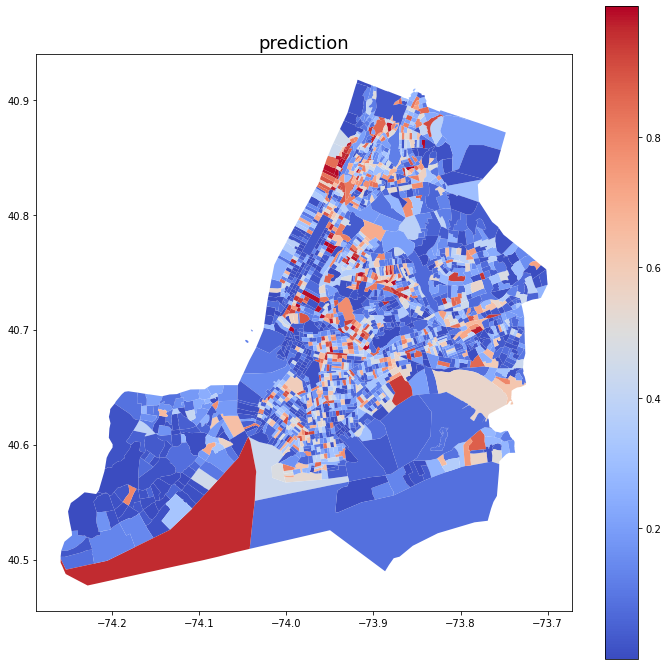

In [ ]:
#Final Predictions
f, ax = plt.subplots(1, figsize=(12, 12))

ax.set_title('prediction', fontsize=18)
spatial_data.plot(axes=ax, column='prediction', legend = True, cmap='coolwarm')

#supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_s...


Logistic Regression with SMOTE correctly determines the equation for gentrification with 82% accuracy. The features that came up as important include decrease in evenness of income and education distribution, proportion change in minority population , income per capita, number of people using public transportaion and percentage change in proportion of people living in 10+ units, in mobile units and spatial lags of income and housing units.

## **Based on literature review and prior critique of gentrification models and early warning systems, our model is novel since it takes into account the dynamic changes in minortiy and white population and distribution of income and education occuring spatially across neighboring tracts**


In [ ]:
redhook = pd.read_csv('/content/redhook_census_tracts.csv')
redhook.head()

,Unnamed: 0,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,sanborn,taxmap,GEOID
0,0,BK,574,32,306,53,1010,15,38,11231,L101,76,4100,3,1D,202 CONOVER STREET,M2-1,K2,5.0,0,NaN,202 CONOVER STREET LLC,2500,4314,4314.0,0.0,0.0,4314.0,0.0,0.0,0.0,0.0,2,0,2.0,0,1,25.00,100.00,25.0,100.0,NaN,1,N,3,0,168750,237600,0,0,2018,0,1.73,0.0,2,0.0,3,3005740032,NaN,53,980120,186237,40.677853,-74.014890,16a,301 002,30207,36047005300
1,1,BK,340,25,306,53,1000,15,39,11231,E202,76,4100,3,2C,UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,18.75,100.00,0.0,0.0,NaN,0,Y,5,5,75150,75150,75150,0,0,0,0.00,0.0,2,0.0,3,3003400025,NaN,53,982598,188825,40.684958,-74.005957,16a,301 006,30202,36047005300
2,2,BK,346,6,306,53,1000,15,39,11231,E202,76,4100,3,2C,55 HAMILTON AVENUE,M2-1,V9,11.0,0,C,PORT AUTHORITY OF NY AND NJ,1196,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,20.00,67.75,0.0,0.0,NaN,0,Y,5,5,65250,65250,65250,0,0,0,0.00,0.0,2,0.0,3,3003460006,NaN,53,982564,188477,40.684002,-74.006079,16a,301 006,30202,36047005300
3,3,BK,541,16,306,53,1024,15,38,11231,L131,76,4100,3,1D,MILL STREET,M1-1,Z9,NaN,1,NaN,581 CLINTON STREET,1786,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,57.00,67.17,0.0,0.0,N,0,Y,3,0,18450,26100,0,0,0,0,0.00,0.0,1,2.4,3,3005410016,NaN,53,983977,185211,40.675038,-74.000984,16c,301 037,30206,36047005300
4,4,BK,340,19,306,53,1000,15,39,11231,E202,76,4100,3,2C,22 UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,25.00,100.00,0.0,0.0,NaN,0,Y,5,5,67950,67950,67950,0,0,0,0.00,0.0,2,0.0,3,3003400019,NaN,53,982491,188874,40.685092,-74.006342,16a,301 006,30202,36047005300


In [ ]:
redhook_df = pd.DataFrame(redhook['GEOID'].unique())
redhook_df = redhook_df.rename(columns={0:'geo_id'})
redhook_df

,geo_id
0,36047005300
1,36047004700
2,36047005900
3,36047008500


In [ ]:
spatial_data_pred_rh = pd.merge(redhook_df,spatial_data_pred,on='geo_id',how='left')
spatial_data_pred_rh.head()

,geo_id,2017_2012_median_income,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,prediction
0,36047005300,0.477189,-0.336917,0.334787,-0.552298,-0.483822,0.400109,-0.162472,0.105122,0.234800,-0.200534,-2.004686,0.284387,-0.018913,-0.149594,0.476599,-0.373595,0.104029
1,36047004700,1.609670,0.924619,0.433338,-1.039171,-0.396156,1.328178,-0.042113,0.066093,0.445954,-0.148942,-1.514947,0.123073,0.071945,0.798939,0.489438,2.261859,0.001049
2,36047005900,0.778186,0.414969,0.577645,-1.367338,-0.647144,0.532107,-0.258072,0.154559,0.157150,0.031245,-0.018048,0.291434,0.287316,-0.277800,-1.324675,0.855128,0.009727
3,36047008500,-2.580590,-0.947253,0.140345,2.305903,0.355605,-1.359598,1.746083,0.211801,-0.785551,-7.917776,-2.047272,-7.699872,2.874068,4.008129,2.461322,1.959197,0.040594


In [ ]:
spatial_data_pred_f = pd.merge(spatial_data,spatial_data_pred_rh[['geo_id','prediction']],on='geo_id',how='inner')
spatial_data_pred_f.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD,gentrified,gentrification_label,lagged_spatial_income,lagged_home_value,lagged_spatial_rent,lagged_income_dist,lagged_white_pop,lagged_other_races,lagged_public_commute,lagged_income_per_capita,lagged_housing_units,lagged_vacant_housing_units,prediction_x,prediction_y
0,36,047,005300,36047005300,53,Census Tract 53,G5020,S,1651843,5374846,+40.6708307,-074.0291182,"POLYGON ((-74.04894 40.66270, -74.04822 40.663...",36047005300,23700.26,719030.0,625.89,-0.097840,0.044499,-1358,-365,537,19067.0,-458,-32,248.0,44600.74,-158222.0,172.81,0.023773,1722,-6883,-1973,9556.0,-1302,-61,-42.1,-14.2,-33.8,-94.9,-92.7,20.6,-17.3,False,0,5600.862500,-1742.375000,220.302500,-0.046223,290.375000,1346.875000,39.750000,499.125000,713.000000,176.875000,0.104029,0.104029
1,36,047,005900,36047005900,59,Census Tract 59,G5020,S,355163,0,+40.6794028,-074.0061193,"POLYGON ((-74.01170 40.67936, -74.01045 40.680...",36047005900,36824.66,822121.0,1031.10,0.119251,0.075785,25,-2563,401,23142.0,-597,-13,191.0,-2550.00,-20605.0,145.48,0.030445,-4819,625,24,-5812.0,-2725,-435,-12.0,-5.7,-17.4,-68.5,0.6,21.5,-4.5,False,0,10625.236667,-14079.666667,-162.836667,0.092511,2163.166667,-223.333333,-7.166667,738.500000,810.166667,68.666667,0.009727,0.009727
2,36,047,004700,36047004700,47,Census Tract 47,G5020,S,283960,0,+40.6883662,-074.0018662,"POLYGON ((-74.00843 40.68602, -74.00816 40.686...",36047004700,73079.84,1188527.0,1255.53,0.266400,0.057195,852,-1678,610,47718.0,-283,-47,403.0,-25141.88,-376779.0,-457.23,0.024705,-1287,2460,66,-24190.0,226,-90,-35.4,-14.0,-13.3,-90.5,-69.7,0.0,-18.6,False,0,7091.600000,89535.000000,223.033333,0.251344,-418.000000,-712.666667,-3.000000,2610.333333,-519.333333,119.333333,0.001049,0.001049
3,36,047,008500,36047008500,85,Census Tract 85,G5020,S,243576,0,+40.6758570,-074.0064716,"POLYGON ((-74.01079 40.67683, -74.01017 40.677...",36047008500,-109628.01,999.0,999.00,-0.274060,0.019451,-2171,7343,1236,-35258.0,2317,9,-501.0,65911.15,63368.0,999.00,0.730531,-1514,-465,0,18904.0,-1090,-184,-1044.3,-1018.3,-19.2,-23.9,-94.7,-999.0,-19.1,False,0,53066.804000,398355.636000,642.462000,0.217171,1132.000000,1084.000000,58.200000,32735.600000,1299.400000,161.800000,0.040594,0.040594


In [ ]:
spatial_data_pred_f.to_file('redhook_gentrification_prediction_2018.json',driver="GeoJSON")

In [ ]:
#Correlations

In [ ]:
df.corr()

,geo_id,2017_2012_median_income,2017_2012_owner_occupied_housing_units_median_value,2017_2012_median_rent,2017_2012_income_dist,2017_2012_edu_dist,2017_2012_white_pop,2017_2012_other_races,2017_2012_commuters_by_public_transportation,2017_2012_income_per_capita,2017_2012_housing_units,2017_2012_vacant_housing_units,2017_2012_bachelors_degree,2012_2011_median_income,2012_2011_owner_occupied_housing_units_median_value,2012_2011_median_rent,2012_2011_income_dist,2012_2011_edu_dist,2012_2011_white_pop,2012_2011_other_races,2012_2011_commuters_by_public_transportation,2012_2011_income_per_capita,2012_2011_housing_units,2012_2011_vacant_housing_units,2012_2011_bachelors_degree,2018_2014_EP_POV,2018_2014_EP_UNEMP,2018_2014_EP_SNGPNT,2018_2014_EP_MINRTY,2018_2014_EP_MUNIT,2018_2014_EP_MOBILE,2018_2014_EP_CROWD
geo_id,1.000000,-0.028222,-0.146826,-0.147339,0.029712,0.051577,0.060547,-0.043250,0.018499,-0.022535,0.043370,0.019658,-0.002025,-0.000170,-0.001462,0.001279,-0.002528,NaN,-0.001645,0.005097,-0.000760,-0.003129,0.003199,0.004049,NaN,-0.011323,-0.002824,-0.073462,-0.111920,-0.115103,-0.010292,-0.084633
2017_2012_median_income,-0.028222,1.000000,0.672426,0.703688,0.624040,-0.026232,0.296775,-0.143466,0.076009,0.826783,0.033041,-0.172849,0.572905,-0.482550,-0.289547,-0.306751,-0.234843,NaN,-0.125560,0.133842,0.017505,-0.364203,0.028771,0.066284,NaN,0.027838,0.035648,-0.034665,-0.041227,-0.057947,0.024800,-0.072503
2017_2012_owner_occupied_housing_units_median_value,-0.146826,0.672426,1.000000,0.729658,0.436522,0.045385,0.022438,0.025643,0.358535,0.707845,0.002887,-0.075336,0.427636,-0.261151,-0.420759,-0.285461,-0.134546,NaN,0.006055,0.054871,-0.116880,-0.268607,0.038900,0.003523,NaN,0.006308,0.008201,-0.099178,-0.068136,-0.089879,0.013070,-0.012749
2017_2012_median_rent,-0.147339,0.703688,0.729658,1.000000,0.495406,-0.073384,0.024162,0.145807,0.272580,0.599903,0.026077,-0.145589,0.478665,-0.260376,-0.262761,-0.434145,-0.144280,NaN,0.012167,0.003532,-0.057498,-0.204249,0.038966,0.028664,NaN,0.021559,0.028956,-0.050927,-0.026372,-0.037071,0.017354,-0.010364
2017_2012_income_dist,0.029712,0.624040,0.436522,0.495406,1.000000,0.140958,0.058798,0.044282,0.073573,0.465796,-0.032005,-0.129649,0.356227,-0.261067,-0.167233,-0.194699,-0.468180,NaN,0.012041,0.015068,-0.001245,-0.173120,0.074951,0.057575,NaN,0.015229,0.017917,-0.003567,0.030641,0.011448,0.017216,0.003673
2017_2012_edu_dist,0.051577,-0.026232,0.045385,-0.073384,0.140958,1.000000,-0.096352,0.015008,0.097448,0.041544,-0.072835,0.025727,-0.148132,0.011129,-0.025604,0.031026,-0.057720,NaN,0.032778,-0.007592,-0.055377,-0.016970,0.034460,0.000618,NaN,0.018606,0.014716,-0.020139,-0.049278,-0.029336,0.022101,-0.044746
2017_2012_white_pop,0.060547,0.296775,0.022438,0.024162,0.058798,-0.096352,1.000000,-0.286598,-0.121967,0.250463,0.648987,0.092392,0.581156,-0.150869,-0.003855,0.002147,0.006407,NaN,-0.478241,0.185157,0.072841,-0.115920,-0.305282,-0.040793,NaN,-0.008559,-0.015294,-0.024052,-0.069574,-0.008464,-0.008217,-0.080916
2017_2012_other_races,-0.043250,-0.143466,0.025643,0.145807,0.044282,0.015008,-0.286598,1.000000,0.287314,-0.263781,0.321747,-0.004026,0.175284,0.142244,0.069115,0.009517,0.020483,NaN,0.172222,-0.454281,-0.099027,0.178743,-0.106017,-0.023948,NaN,0.010530,0.001919,0.045359,0.076589,0.044999,-0.003343,0.105308
2017_2012_commuters_by_public_transportation,0.018499,0.076009,0.358535,0.272580,0.073573,0.097448,-0.121967,0.287314,1.000000,0.144135,0.125056,-0.034948,0.215215,0.021342,-0.133655,-0.075370,0.007030,NaN,0.071431,-0.101475,-0.456087,-0.027363,-0.034163,-0.002207,NaN,0.015700,0.009832,-0.012940,0.024647,0.007655,0.016559,0.074621
2017_2012_income_per_capita,-0.022535,0.826783,0.707845,0.599903,0.465796,0.041544,0.250463,-0.263781,0.144135,1.000000,0.113251,-0.016183,0.554233,-0.382097,-0.314534,-0.258210,-0.164653,NaN,-0.099199,0.177818,-0.028422,-0.450662,-0.019522,-0.007833,NaN,0.024320,0.030664,-0.049540,-0.056915,-0.037350,0.024247,-0.070515


In [ ]:
df.corr().to_csv('demographic_correlations.csv')